### 옷 종류 데이터 FashionMNIST를 활용해 AutoEncoder 설계하기

In [46]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [47]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version: ', torch.__version__, ' Device : ', DEVICE)

Using PyTorch version:  2.0.1+cu118  Device :  cuda


In [48]:
BATCH_SIZE = 32
EPOCHS = 10

In [49]:
''' 3. FashionMNIST 데이터 다운로드(Train set, Test set 분리하기) '''
train_dataset = datasets.FashionMNIST(root = '/content/data/FashionMNIST',
                                      train = True,
                                      download = True,
                                      transform = transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root = '/content/data/FashionMNIST',
                                     train = False,
                                     transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

In [50]:
''' 4. 데이터 확인하기 (1) '''
for (x_train, y_train) in train_loader:
    print('x_train : ', x_train.size(), ' type : ', x_train.type())
    print('y_train : ', y_train.size(), ' type : ', y_train.type())
    break

x_train :  torch.Size([32, 1, 28, 28])  type :  torch.FloatTensor
y_train :  torch.Size([32])  type :  torch.LongTensor


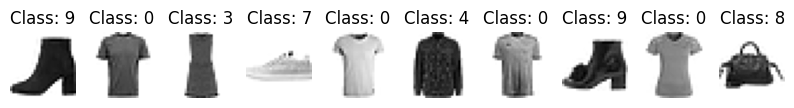

In [51]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10*pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(x_train[i, :, :, :].numpy().reshape(28,28), cmap= "gray_r")
    plt.title("Class: " + str(y_train[i].item()))

In [52]:
''' 6. AutoEncoder(AE) 모델 설계하기 '''
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256, 32),
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [53]:
''' 7. Optimizer, Objective Function 설정하기 '''
model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [54]:
''' 8. AE 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, _) in enumerate(train_loader):
        image = image.view(-1, 28 * 28).to(DEVICE)
        target = image.view(-1, 28 * 28).to(DEVICE)
        optimizer.zero_grad()
        encoded, decoded = model(image)
        loss = criterion(decoded, target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
                Epoch, batch_idx * len(image),
                len(train_loader.dataset), 100 * batch_idx / len(train_loader),
                loss.item()
            ))

In [57]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    real_image = []
    gen_image = []
    with torch.no_grad():
        for image, _ in test_loader:
            image = image.view(-1, 28*28).to(DEVICE)
            target = image.view(-1, 28*28).to(DEVICE)
            encoded, decoded = model(image)

            test_loss += criterion(decoded, image).item()
            real_image.append(image.to("cpu"))
            gen_image.append(image.to("cpu"))

    test_loss /= len(test_loader.dataset)
    return test_loss, real_image, gen_image

Train Epoch: 1 [0/60000(0%)]	Train Loss: 0.012448
Train Epoch: 1 [6400/60000(11%)]	Train Loss: 0.012024
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 0.012266
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 0.010429
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 0.013250
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 0.010379
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 0.011203
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 0.012942
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 0.011219
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 0.010059

[EPOCH: 1], 	Test Loss: 0.0004


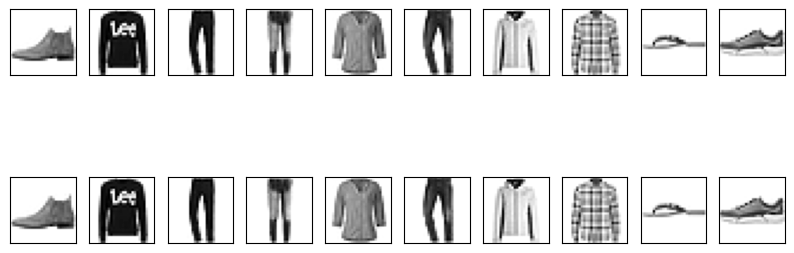

Train Epoch: 2 [0/60000(0%)]	Train Loss: 0.011469
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 0.010193
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 0.011496
Train Epoch: 2 [19200/60000(32%)]	Train Loss: 0.010319
Train Epoch: 2 [25600/60000(43%)]	Train Loss: 0.010867
Train Epoch: 2 [32000/60000(53%)]	Train Loss: 0.011227
Train Epoch: 2 [38400/60000(64%)]	Train Loss: 0.010430
Train Epoch: 2 [44800/60000(75%)]	Train Loss: 0.010852
Train Epoch: 2 [51200/60000(85%)]	Train Loss: 0.011503
Train Epoch: 2 [57600/60000(96%)]	Train Loss: 0.011368

[EPOCH: 2], 	Test Loss: 0.0003


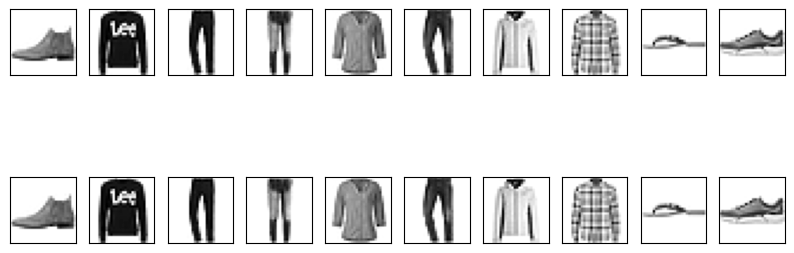

Train Epoch: 3 [0/60000(0%)]	Train Loss: 0.009950
Train Epoch: 3 [6400/60000(11%)]	Train Loss: 0.010574
Train Epoch: 3 [12800/60000(21%)]	Train Loss: 0.008669
Train Epoch: 3 [19200/60000(32%)]	Train Loss: 0.012417
Train Epoch: 3 [25600/60000(43%)]	Train Loss: 0.008758
Train Epoch: 3 [32000/60000(53%)]	Train Loss: 0.013216
Train Epoch: 3 [38400/60000(64%)]	Train Loss: 0.009344
Train Epoch: 3 [44800/60000(75%)]	Train Loss: 0.014834
Train Epoch: 3 [51200/60000(85%)]	Train Loss: 0.009936
Train Epoch: 3 [57600/60000(96%)]	Train Loss: 0.011887

[EPOCH: 3], 	Test Loss: 0.0003


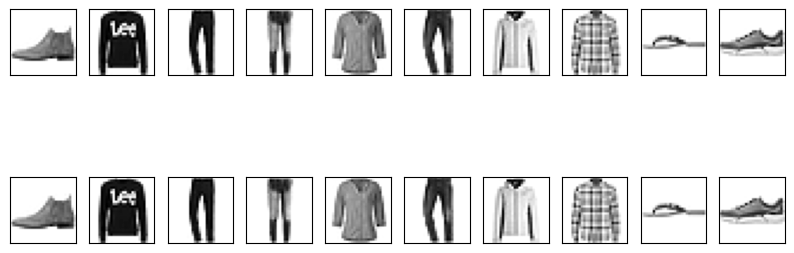

Train Epoch: 4 [0/60000(0%)]	Train Loss: 0.011738
Train Epoch: 4 [6400/60000(11%)]	Train Loss: 0.012360
Train Epoch: 4 [12800/60000(21%)]	Train Loss: 0.011419
Train Epoch: 4 [19200/60000(32%)]	Train Loss: 0.010334
Train Epoch: 4 [25600/60000(43%)]	Train Loss: 0.012208
Train Epoch: 4 [32000/60000(53%)]	Train Loss: 0.011072
Train Epoch: 4 [38400/60000(64%)]	Train Loss: 0.010333
Train Epoch: 4 [44800/60000(75%)]	Train Loss: 0.009289
Train Epoch: 4 [51200/60000(85%)]	Train Loss: 0.010816
Train Epoch: 4 [57600/60000(96%)]	Train Loss: 0.010109

[EPOCH: 4], 	Test Loss: 0.0003


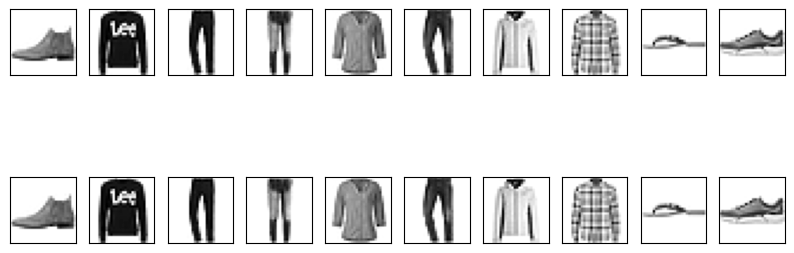

Train Epoch: 5 [0/60000(0%)]	Train Loss: 0.008861
Train Epoch: 5 [6400/60000(11%)]	Train Loss: 0.010113
Train Epoch: 5 [12800/60000(21%)]	Train Loss: 0.012549
Train Epoch: 5 [19200/60000(32%)]	Train Loss: 0.009712
Train Epoch: 5 [25600/60000(43%)]	Train Loss: 0.008601
Train Epoch: 5 [32000/60000(53%)]	Train Loss: 0.015213
Train Epoch: 5 [38400/60000(64%)]	Train Loss: 0.009791
Train Epoch: 5 [44800/60000(75%)]	Train Loss: 0.009058
Train Epoch: 5 [51200/60000(85%)]	Train Loss: 0.009692
Train Epoch: 5 [57600/60000(96%)]	Train Loss: 0.011862

[EPOCH: 5], 	Test Loss: 0.0003


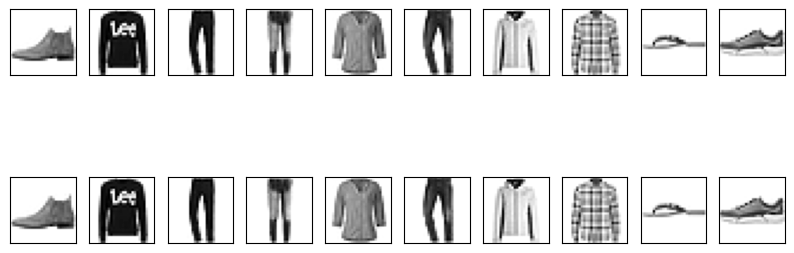

Train Epoch: 6 [0/60000(0%)]	Train Loss: 0.008733
Train Epoch: 6 [6400/60000(11%)]	Train Loss: 0.011432
Train Epoch: 6 [12800/60000(21%)]	Train Loss: 0.008302
Train Epoch: 6 [19200/60000(32%)]	Train Loss: 0.012925
Train Epoch: 6 [25600/60000(43%)]	Train Loss: 0.011039
Train Epoch: 6 [32000/60000(53%)]	Train Loss: 0.009989
Train Epoch: 6 [38400/60000(64%)]	Train Loss: 0.009185
Train Epoch: 6 [44800/60000(75%)]	Train Loss: 0.009642
Train Epoch: 6 [51200/60000(85%)]	Train Loss: 0.008011
Train Epoch: 6 [57600/60000(96%)]	Train Loss: 0.008380

[EPOCH: 6], 	Test Loss: 0.0003


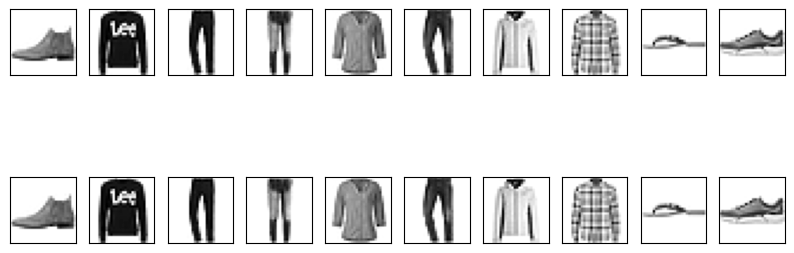

Train Epoch: 7 [0/60000(0%)]	Train Loss: 0.012009
Train Epoch: 7 [6400/60000(11%)]	Train Loss: 0.009123
Train Epoch: 7 [12800/60000(21%)]	Train Loss: 0.008364
Train Epoch: 7 [19200/60000(32%)]	Train Loss: 0.010322
Train Epoch: 7 [25600/60000(43%)]	Train Loss: 0.009202
Train Epoch: 7 [32000/60000(53%)]	Train Loss: 0.011346
Train Epoch: 7 [38400/60000(64%)]	Train Loss: 0.008514
Train Epoch: 7 [44800/60000(75%)]	Train Loss: 0.008967
Train Epoch: 7 [51200/60000(85%)]	Train Loss: 0.009010
Train Epoch: 7 [57600/60000(96%)]	Train Loss: 0.010925

[EPOCH: 7], 	Test Loss: 0.0003


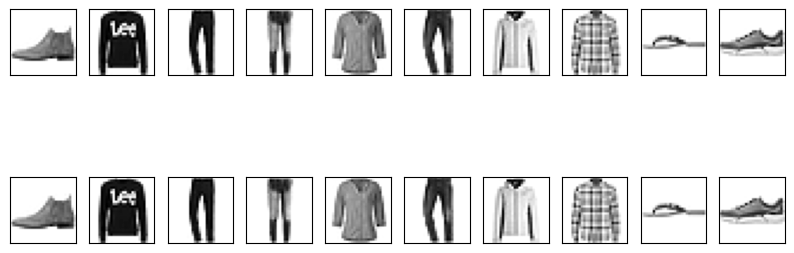

Train Epoch: 8 [0/60000(0%)]	Train Loss: 0.011550
Train Epoch: 8 [6400/60000(11%)]	Train Loss: 0.007948
Train Epoch: 8 [12800/60000(21%)]	Train Loss: 0.009212
Train Epoch: 8 [19200/60000(32%)]	Train Loss: 0.010045
Train Epoch: 8 [25600/60000(43%)]	Train Loss: 0.009148
Train Epoch: 8 [32000/60000(53%)]	Train Loss: 0.009348
Train Epoch: 8 [38400/60000(64%)]	Train Loss: 0.011693
Train Epoch: 8 [44800/60000(75%)]	Train Loss: 0.007191
Train Epoch: 8 [51200/60000(85%)]	Train Loss: 0.007298
Train Epoch: 8 [57600/60000(96%)]	Train Loss: 0.007853

[EPOCH: 8], 	Test Loss: 0.0003


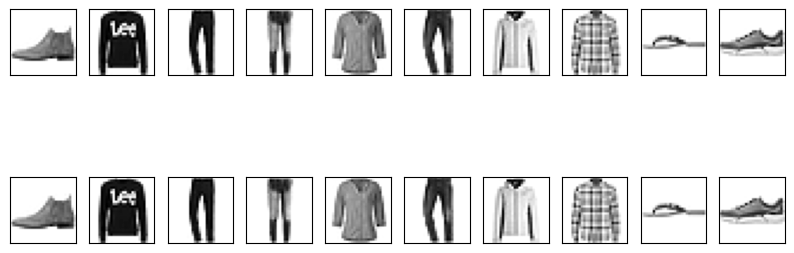

Train Epoch: 9 [0/60000(0%)]	Train Loss: 0.007986
Train Epoch: 9 [6400/60000(11%)]	Train Loss: 0.010873
Train Epoch: 9 [12800/60000(21%)]	Train Loss: 0.009150
Train Epoch: 9 [19200/60000(32%)]	Train Loss: 0.009471
Train Epoch: 9 [25600/60000(43%)]	Train Loss: 0.010754
Train Epoch: 9 [32000/60000(53%)]	Train Loss: 0.011156
Train Epoch: 9 [38400/60000(64%)]	Train Loss: 0.009408
Train Epoch: 9 [44800/60000(75%)]	Train Loss: 0.009040
Train Epoch: 9 [51200/60000(85%)]	Train Loss: 0.010410
Train Epoch: 9 [57600/60000(96%)]	Train Loss: 0.009630

[EPOCH: 9], 	Test Loss: 0.0003


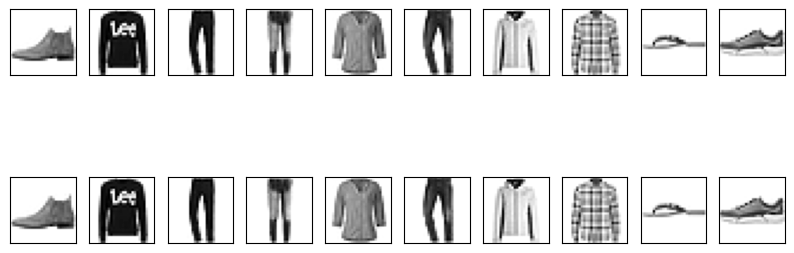

Train Epoch: 10 [0/60000(0%)]	Train Loss: 0.011140
Train Epoch: 10 [6400/60000(11%)]	Train Loss: 0.008389
Train Epoch: 10 [12800/60000(21%)]	Train Loss: 0.008950
Train Epoch: 10 [19200/60000(32%)]	Train Loss: 0.008723
Train Epoch: 10 [25600/60000(43%)]	Train Loss: 0.011745
Train Epoch: 10 [32000/60000(53%)]	Train Loss: 0.008780
Train Epoch: 10 [38400/60000(64%)]	Train Loss: 0.007714
Train Epoch: 10 [44800/60000(75%)]	Train Loss: 0.008860
Train Epoch: 10 [51200/60000(85%)]	Train Loss: 0.012529
Train Epoch: 10 [57600/60000(96%)]	Train Loss: 0.010941

[EPOCH: 10], 	Test Loss: 0.0003


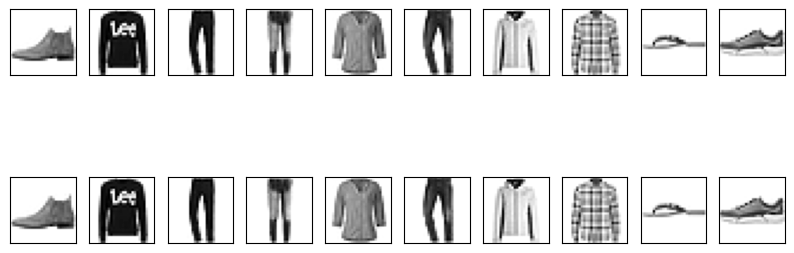

In [60]:
''' 10. AutoEncoder 학습을 실행하며 Test set의 Reconstruction Error 확인하기 '''
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, real_image, gen_image = evaluate(model, test_loader)
    print('\n[EPOCH: {}], \tTest Loss: {:.4f}'.format(Epoch, test_loss))
    f, a = plt.subplots(2, 10, figsize=(10, 4))
    for i in range(10):
        img = np.reshape(real_image[0][i],(28, 28))
        a[0][i].imshow(img, cmap = "gray_r")
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())

    for i in range(10):
        img = np.reshape(gen_image[0][i],(28,28))
        a[1][i].imshow(img, cmap="gray_r")
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show()